In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numba import jit
import datetime
%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Read and clean data

This data is all hands played on each hour on the site

In [26]:
data = pd.read_csv('hourly_all_dummies.csv')
daily = pd.read_csv('daily_dummies.csv')
sessions = pd.read_csv('c:/users/matt/desktop/poker paper/sessions_dummies.csv')

# Clean Daily dataset
daily = daily.drop('Unnamed: 0', 1)

# Clean Sessions dataset
sessions['Session Start'] = pd.to_datetime(sessions['Session Start'])
sessions = sessions.sort_values(by='Session Start')
sessions = sessions.drop('Unnamed: 0', axis=1)
sessions = sessions.reset_index()
sessions = sessions.drop('index', 1)

In [3]:
# New dataset from grouped sessions average daily
daily_sessions = sessions.copy()
daily_sessions2 = sessions.copy()
daily_sessions = daily_sessions.groupby(daily_sessions.set_index('Session Start').index.date).mean()
daily_sessions2 = daily_sessions2.groupby(daily_sessions2.set_index('Session Start').index.date).median()
daily_sessions = daily_sessions.loc[:, :'Sunday']
daily_sessions['Minutes_median'] = daily_sessions2['Minutes']

In [4]:
data['Time'] = np.zeros(len(data))
data['Time^2'] = np.zeros(len(data))
data['Time*Treat'] = np.zeros(len(data))
data['Time*Treat^2'] = np.zeros(len(data))
data['lnHands'] = np.log(data['Hands'])
data['lnRake'] = np.log(data['Rake'])

daily['Time'] = np.zeros(len(daily))
daily['Time^2'] = np.zeros(len(daily))
daily['Time*Treat'] = np.zeros(len(daily))
daily['Time*Treat^2'] = np.zeros(len(daily))
daily['lnHands'] = np.log(daily['Hands'])
daily['lnRake'] = np.log(daily['Rake'])

In [5]:
for i in range(len(data)):
    data.loc[i, 'Time'] = i
    data.loc[i, 'Time*Treat'] = data.loc[i, 'Treat'] * (i - 62)
    data.loc[i, 'Time^2'] = i**2
    data.loc[i, 'Time*Treat^2'] = data.loc[i, 'Treat'] * (i**2 - 62)
    
for i in range(len(daily)):
    daily.loc[i, 'Time'] = i
    daily.loc[i, 'Time*Treat'] = daily.loc[i, 'Treat'] * (i - 62)
    daily.loc[i, 'Time^2'] = i**2
    daily.loc[i, 'Time*Treat^2'] = daily.loc[i, 'Treat'] * (i**2 - 62)

# OLS on hands and rake aggregates

- Model on constant + dummies to test for intercept change

In [6]:
#
# OLS with quadratic time and interaction effects time* treat (and quad interaction)
#
X = data.loc[:, 'Treat':'Time*Treat^2'].drop('After', 1)
Xday = daily.loc[:, 'Treat':'Time*Treat^2']#.drop('After', 1)
X = sm.add_constant(X)
Xday = sm.add_constant(Xday)
rake = data[['Rake']]
rake_day = daily[['Rake']]
hands = data[['Hands']]
hands_day= daily[['Hands']]
lograke = data[['lnRake']]
lograke_day = daily[['lnRake']]
loghands = data[['lnHands']]
loghands_day = daily[['lnHands']]

In [7]:
rake1 = sm.OLS(rake, X).fit(cov_type='HC1')
rake1_day = sm.OLS(rake_day, Xday).fit(cov_type='HC1')
hands1 = sm.OLS(hands, X).fit(cov_type='HC1')
hands1_day = sm.OLS(hands_day, Xday).fit(cov_type='HC1')

In [8]:
#
# OLS without quadratic time or time*treat
#
X2 = data.loc[:, 'Treat':'Time'].drop('After', 1)
X2 = sm.add_constant(X2)
rake = data[['Rake']]
hands = data[['Hands']]
lograke = data[['lnRake']]
loghands = data[['lnHands']]

In [9]:
hands2 = sm.OLS(hands, X2).fit(cov_type='HC1')
rake2 = sm.OLS(rake, X2).fit(cov_type='HC1')
lnrake2 = sm.OLS(lograke, X2).fit(cov_type='HC1')
lnhands2 = sm.OLS(loghands, X2).fit(cov_type='HC1')

In [10]:
#
# OLS with "Learning"
#
X3 = data.loc[:, 'Tuesday':'Time'].drop('Time', 1) # Drop time?
X3['After'] = data['After']# Keep After dummy in

# First cutoff @ 1453
X3['Week 1'] = ((X3.index >= 1453) & (X3.index < 1620)).astype(int)
X3['Week 2'] = ((X3.index >= 1620) & (X3.index < 1787)).astype(int)
X3['Week 3'] = ((X3.index >= 1787) & (X3.index < 1954)).astype(int)
X3['Week 4'] = ((X3.index >= 1954) & (X3.index < 2121)).astype(int)
X3['Week 5'] = ((X3.index >= 2121) & (X3.index < 2288)).astype(int)
X3['Week 6'] = ((X3.index >= 2288) & (X3.index < 2455)).astype(int)
X3['Week 7'] = ((X3.index >= 2455) & (X3.index < 2622)).astype(int)
X3['Week 8'] = ((X3.index >= 2622) & (X3.index < 2789)).astype(int)
X3['Week 9'] = ((X3.index >= 2789) & (X3.index < 2959)).astype(int)
# Second cutoff @ 2959

X3 = sm.add_constant(X3)

In [11]:
hands_learn = sm.OLS(hands, X3).fit(cov_type='HC1')
rake_learn = sm.OLS(rake, X3).fit(cov_type='HC1')
lnrake_learn = sm.OLS(lograke, X3).fit(cov_type='HC1')
lnhands_learn = sm.OLS(loghands, X3).fit(cov_type='HC1')

** Plots & Summary **

In [12]:
#hands_learn.summary()

In [13]:
ddhands = data.reset_index()
ddhands['index'] = ddhands.index

fitted_hands = hands2.fittedvalues.copy()
fitted_hands = fitted_hands.reset_index()
fitted_hands.columns = ['index', 'fit']

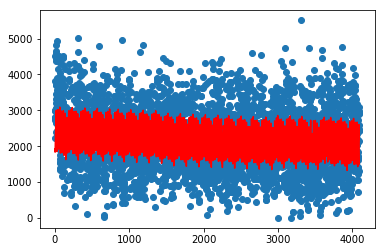

In [14]:
plt.scatter(ddhands.index, ddhands['Hands'])
plt.plot(fitted_hands['fit'], 'r')

# OLS on sessions time

In [15]:
Xsessions = sessions.loc[:, 'Treat':]#.drop('After', 1)
Xsessions_day = daily_sessions.loc[:, 'Treat':'Sunday']#.drop('After', 1)
Xsessions = sm.add_constant(Xsessions)
Xsessions_day = sm.add_constant(Xsessions_day)
minutes_sessions = sessions[['Minutes']]
logminutes_sessions = np.log(sessions['Minutes'])

In [16]:
minutes1 = sm.OLS(minutes_sessions, Xsessions).fit(cov_type='HC1')
minutes_day1 = sm.OLS(daily_sessions[['Minutes']], Xsessions_day).fit(cov_type='HC1')
#minutes1.summary()
#minutes_day1.summary()

In [17]:
#
# Sessions with Learning
#
Xsessions2 = sessions.loc[:, 'After':]#.drop('Time', 1)    # Drop Time?
Xsessions2['Week 1'] = ((Xsessions2.index >= 1453) & (Xsessions2.index < 1620)).astype(int)
Xsessions2['Week 2'] = ((Xsessions2.index >= 1620) & (Xsessions2.index < 1787)).astype(int)
Xsessions2['Week 3'] = ((Xsessions2.index >= 1787) & (Xsessions2.index < 1954)).astype(int)
Xsessions2['Week 4'] = ((Xsessions2.index >= 1954) & (Xsessions2.index < 2121)).astype(int)
Xsessions2['Week 5'] = ((Xsessions2.index >= 2121) & (Xsessions2.index < 2288)).astype(int)
Xsessions2['Week 6'] = ((Xsessions2.index >= 2288) & (Xsessions2.index < 2455)).astype(int)
Xsessions2['Week 7'] = ((Xsessions2.index >= 2455) & (Xsessions2.index < 2622)).astype(int)
Xsessions2['Week 8'] = ((Xsessions2.index >= 2622) & (Xsessions2.index < 2789)).astype(int)
Xsessions2['Week 9'] = ((Xsessions2.index >= 2789) & (Xsessions2.index < 2959)).astype(int)
Xsessions2 = sm.add_constant(Xsessions2)

In [18]:
minutes_learn = sm.OLS(minutes_sessions, Xsessions2).fit(cov_type='HC1')
#minutes_learn.summary()

** Plots **

In [19]:
ddsession = sessions.reset_index()
ddsession['index'] = ddsession.index

fitted_day = minutes1.fittedvalues.copy()
fitted_day = fitted_day.reset_index()
fitted_day.columns = ['index', 'fit']

In [20]:
#plt.scatter(ddsession.index, sessions['Minutes'])
#plt.plot(fitted_day['fit'], 'r')

# RDD

In [21]:
# Detrended versions of Hands series
rddata_detrended_hands = sm.OLS(data['Hands'], sm.add_constant(data.loc[:, 'Tuesday':'11PM'])).fit().resid
rddata_detrended_hands = pd.DataFrame(rddata_detrended_hands)
rddata_detrended_hands['Treat'] = data['Treat']
rddata_detrended_hands.columns = ['Hands', 'Treat']
# Detrended daily
rddaily_detrended_hands = sm.OLS(daily['Hands'][:177], sm.add_constant(daily.loc[:, 'Tuesday':'Sunday'])[:177]).fit().resid
rddaily_detrended_hands = pd.DataFrame(rddaily_detrended_hands)
rddaily_detrended_hands['Treat'] = daily['Treat']
rddaily_detrended_hands.columns = ['Hands', 'Treat']
# Detrended versions of Minutes time series
rdsession_detrended_minutes = sm.OLS(daily_sessions['Minutes'], sm.add_constant(daily_sessions.loc[:, 'Tuesday':'Sunday'])).fit().resid
rdsession_detrended_minutes = pd.DataFrame(rdsession_detrended_minutes)
rdsession_detrended_minutes['Treat'] = daily_sessions['Treat']
rdsession_detrended_minutes.columns = ['Minutes', 'Treat']

In [22]:
rddata = data.loc[1000:2000] #Cutoff is at 1453rd observation
rddata_detrended_hands = rddata_detrended_hands[1000:2000]
rddaily = daily.loc[20:105] #Cutoff is at 62nd obs
rddaily_detrended_hands = rddaily_detrended_hands[20:105]
rdsession = daily_sessions.iloc[20:105] #Cutoff same as above
rdsession_detrended_minutes = rdsession_detrended_minutes[20:105]


# Reset the index to create the forcing RDD variable
def reset_data_index(data_in):
    data_in = data_in.reset_index()
    data_in['index'] = data_in.index
    data_in['forcing'] = data_in.index
    return data_in


# Make index X-cutoff by finding location of cutoff
def get_cutoff_index(indata):
    for i in range(len(indata)):
        if indata['Treat'][i] == 0:
            continue
        return i

#
# HOUR data cleaning
#
rddata = reset_data_index(rddata)
cutoff_loc = get_cutoff_index(rddata)
rddata['index'] -= cutoff_loc

# Detrended
rddata_detrended_hands = reset_data_index(rddata_detrended_hands)
cutoff_loc = get_cutoff_index(rddata_detrended_hands)
rddata_detrended_hands['index'] -= cutoff_loc

#
# DAILY data cleaning
#
rddaily = reset_data_index(rddaily)
cutoff_loc =  get_cutoff_index(rddaily)
rddaily['index'] -= cutoff_loc
# Detrended
rddaily_detrended_hands = reset_data_index(rddaily_detrended_hands)
cutoff_loc = get_cutoff_index(rddaily_detrended_hands)
rddaily_detrended_hands['index'] -= cutoff_loc

#
# SESSIONS data cleaning
#
rdsession = reset_data_index(rdsession)
cutoff_loc =  get_cutoff_index(rdsession)
rdsession['index'] -= cutoff_loc
# Detrended
rdsession_detrended_minutes = reset_data_index(rdsession_detrended_minutes)
cutoff_loc =  get_cutoff_index(rdsession_detrended_minutes)
rdsession_detrended_minutes['index'] -= cutoff_loc

In [177]:
def create_rd_indeces(indata):
    indata['index2'] = indata['index']**2
    indata['index3'] = indata['index']**3
    indata['treatIndex'] = indata['index'] * indata['Treat']
    indata['treatIndex2'] = rddata['index2'] * indata['Treat']
    indata['treatIndex3'] = indata['index3'] * indata['Treat']
    return indata

rddata = create_rd_indeces(rddata)
rddata_detrended_hands = create_rd_indeces(rddata_detrended_hands)
rddaily = create_rd_indeces(rddaily)
rddaily_detrended_hands = create_rd_indeces(rddaily_detrended_hands)
rdsession = create_rd_indeces(rdsession)
rdsession_detrended_minutes = create_rd_indeces(rdsession_detrended_minutes)

**Rake RDD**

In [178]:
rd_rake3_inter = smf.ols("Rake ~ Treat + index + index2 + index3 + \
                          treatIndex + treatIndex2 + treatIndex3", rddata).fit(cov_type='HC1')

rd_rake3 = smf.ols("Rake ~ Treat + index + index2 + index3", rddata).fit(cov_type='HC1')

rd_rake3_inter_daily = smf.ols("Rake ~ Treat + index + index2 + index3 + \
                                treatIndex + treatIndex2 + treatIndex3", rddaily).fit(cov_type='HC1')

rd_rake3_daily = smf.ols("Rake ~ Treat + index + index2 + index3", rddaily).fit(cov_type='HC1')
#rd_rake3_inter.summary()
#rd_rake3.summary()
#rd_rake3_inter_daily.summary()
#rd_rake3_daily.summary()

In [179]:
rd_rake2_inter = smf.ols("Rake ~ Treat + index + index2 + treatIndex + treatIndex2", rddata).fit(cov_type='HC1')
rd_rake2 = smf.ols("Rake ~ Treat + index + index2", rddata).fit(cov_type='HC1')
rd_rake2_inter_daily = smf.ols("Rake ~ Treat + index + index2 + treatIndex + treatIndex2", rddaily).fit(cov_type='HC1')
rd_rake2_daily = smf.ols("Rake ~ Treat + index + index2", rddaily).fit(cov_type='HC1')
#rd_rake2_inter.summary()
#rd_rake2.summary()
#rd_rake2_inter_daily.summary()
#rd_rake2_daily.summary()

**Hands RDD**

In [204]:
rd_hands2_inter = smf.ols("Hands ~ Treat + index + index2 + treatIndex + treatIndex2", rddata).fit(cov_type='HC1')
rd_hands2_inter_detrended = smf.ols("Hands ~ Treat + index + index2 + treatIndex + treatIndex2", rddata_detrended_hands).fit(cov_type='HC1')
rd_hands2_inter_daily = smf.ols("Hands ~ Treat + index + index2 + treatIndex + treatIndex2", rddaily).fit(cov_type='HC1')
rd_hands2_inter_daily_detrended = smf.ols("Hands ~ Treat + index + index2 + treatIndex + treatIndex2", rddaily_detrended_hands).fit(cov_type='HC1')
#rd_hands2_inter.summary()
#rd_hands2_inter_detrended.summary()
#rd_hands2_inter_daily.summary()
#rd_hands2_inter_daily_detrended.summary()

In [199]:
rd_hands3_inter = smf.ols("Hands ~ Treat + index + index2 + index3 + \
                            treatIndex + treatIndex2 + treatIndex3", rddata).fit(cov_type='HC1')
rd_hands3_inter_detrended = smf.ols("Hands ~ Treat + index + index2 + index3 + \
                            treatIndex + treatIndex2 + treatIndex3", rddata_detrended_hands).fit(cov_type='HC1')
rd_hands3_inter_daily = smf.ols("Hands ~ Treat + index + index2 + index3 + \
                                 treatIndex + treatIndex2 + treatIndex3", rddaily).fit(cov_type='HC1')
rd_hands3_inter_daily_detrended = smf.ols("Hands ~ Treat + index + index2 + index3 + \
                                 treatIndex + treatIndex2 + treatIndex3", rddaily_detrended_hands).fit(cov_type='HC1')
#rd_hands3_inter.summary()
#rd_hands3_inter_detrended.summary()
#rd_hands3_inter_daily.summary()
#rd_hands3_inter_daily_detrended.summary()

**Avg Minutes RDD**

Change "Minutes ~ ..." to "Minutes median ~ ..." For median minutes

In [191]:
rd_min2_inter_daily = smf.ols("Minutes ~ Treat + index + index2 + treatIndex + treatIndex2", rdsession).fit(cov_type='HC1')
rd_min2_inter_daily_detrended = smf.ols("Minutes ~ Treat + index + index2 + \
                                        treatIndex + treatIndex2", rdsession_detrended_minutes).fit(cov_type='HC1')
#rd_min2_inter_daily_detrended.summary()
#rd_min2_inter_daily.summary()

In [194]:
rd_min3_inter_daily = smf.ols("Minutes ~ Treat + index + index2 + index3 + \
                                 treatIndex + treatIndex2 + treatIndex3", rdsession).fit(cov_type='HC1')
rd_min3_inter_daily_detrended = smf.ols("Minutes ~ Treat + index + index2 + index3 + \
                                 treatIndex + treatIndex2 + treatIndex3", rdsession_detrended_minutes).fit(cov_type='HC1')
#rd_min3_inter_daily.summary()
#rd_min3_inter_daily_detrended.summary()

** Plot **

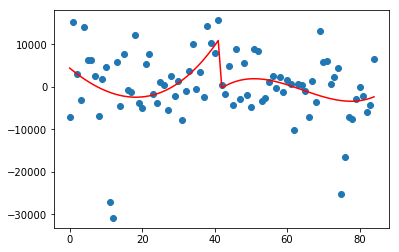

In [205]:
plt.scatter(rddaily_detrended_hands['forcing'], rddaily_detrended_hands['Hands'])
plt.plot(rd_hands3_inter_daily_detrended.fittedvalues, 'r')

# RD of 2nd cutoff

In [20]:
rddata2 = data.loc[2500:3500] #Cutoff is at 2959 observation
rddaily2 = daily.loc[85:155] #Cutoff is at 125nd obs

rddata2 = rddata2.reset_index()
rddata2['index'] = rddata2.index
rddata2['forcing'] = rddata2.index

rddata2['index'] -= get_cutoff_index(rddata2)

rddaily2 = rddaily2.reset_index()
rddaily2['index'] = rddaily2.index
rddaily2['forcing'] = rddaily2.index

rddaily2['index'] -= get_cutoff_index(rddaily2)

In [21]:
rddata2['index2'] = rddata2['index']**2
rddata2['index3'] = rddata2['index']**3
rddata2['treatIndex'] = rddata2['index'] * rddata2['Treat']
rddata2['treatIndex2'] = rddata2['index2'] * rddata2['Treat']
rddata2['treatIndex3'] = rddata2['index3'] * rddata2['Treat']

rddaily2['index2'] = rddaily2['index']**2
rddaily2['index3'] = rddaily2['index']**3
rddaily2['treatIndex'] = rddaily2['index'] * rddaily2['Treat']
rddaily2['treatIndex2'] = rddaily2['index2'] * rddaily2['Treat']
rddaily2['treatIndex3'] = rddaily2['index3'] * rddaily2['Treat']

**Rake RDD (2nd shock)**

In [22]:
after_rd_rake3_inter = smf.ols("Rake ~ After + index + index2 + index3 + \
                                treatIndex + treatIndex2 + treatIndex3", rddata2).fit(cov_type='HC1')
after_rd_rake3_inter_daily = smf.ols("Rake ~ After + + index + index2 + index3 +\
                                      treatIndex + treatIndex2 + treatIndex3", rddaily2).fit(cov_type='HC1')

after_rd_rake3_daily = smf.ols("Rake ~ Treat + index + index2 + index3", rddaily2).fit(cov_type='HC1')
#after_rd_rake3_inter.summary()
#after_rd_rake3_inter_daily.summary()
#after_rd_rake3_daily.summary()

In [23]:
after_rd_rake2_inter = smf.ols("Rake ~ After + + index + index2 + treatIndex + treatIndex2", rddata2).fit(cov_type='HC1')
after_rd_rake2_inter_daily = smf.ols("Rake ~ After + + index + index2 + treatIndex + treatIndex2", rddaily2).fit(cov_type='HC1')
#after_rd_rake2_inter.summary()
#after_rd_rake2_inter_daily.summary()

**Hands RDD (2nd shock)**

In [24]:
after_rd_hands2_inter = smf.ols("Hands ~ After + + index + index2 + treatIndex + treatIndex2", rddaily2).fit(cov_type='HC1')
after_rd_hands2_inter_daily = smf.ols("Hands ~ After + + index + index2 + treatIndex + treatIndex2", rddaily2).fit(cov_type='HC1')
#after_rd_hands2_inter.summary()
#after_rd_hands2_inter_daily.summary()

In [25]:
after_rd_hands3_inter = smf.ols("Hands ~ After + index + index2 + index3 + treatIndex + treatIndex2 + treatIndex3", rddaily2).fit(cov_type='HC1')
after_rd_hands3_inter_daily = smf.ols("Hands ~ After + + index + index2 + index3 + treatIndex + treatIndex2 + treatIndex3", rddaily2).fit(cov_type='HC1')
#after_rd_hands3_inter.summary()
#after_rd_hands3_inter_daily.summary()

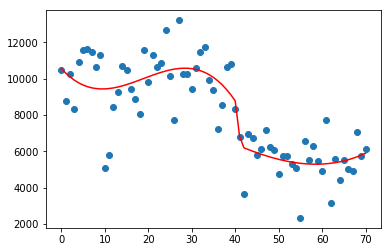

In [26]:
plt.scatter(rddaily2['index'], rddaily2['Rake'])
plt.plot(after_rd_rake3_inter_daily.fittedvalues, 'r')